Author: [Tony Yum](https://www.linkedin.com/in/tonyyum/)

# Remote Importing of Python Modules

## Introduction

Python is an extremely dynamic and flexible language. In this demo, the goal is to show how we can use python’s path_hooks mechanism to change imports from using local filesystem to a remote source.

As a bonus, this article also demonstrates creating necessary AWS resources via Cloudformation and how to remove them with a single command. There will be some basic performance analysis of the each remote source.

## Why do we want remote import?

But hang on a second, why are we doing this? Is it a good idea to load sources remotely?

Yes, there are many reasons why it is a good idea. 

It allows rapid prototyping - server clusters can pick up code changes by simply bouncing the server or even importlib.reload
Code sharing - developer could create a simple script that reproduce an issue or demo and ask someone else to take a look by simply running against the repro staging area.
UAT staging area can contain only scripts ready to be shipped and testing jobs can run against UAT and backed by production source.
Hot fixes - production source can have an empty hotfix db sitting in front of it so that when an urgent bug fix is required, one only needs to move that script into the hotfix source db.
Time travelling - we could add a source marker to define a version or point in time, such that all imports would happen as if we have time travelled.

## Other Concerns

**Wouldn’t it be slow?**

Yes it would be slower, but as the demo later shows, using an in-memory cache such as Redis yields great performance. We must also not forget that in comparison to having to build a new container or other deployment strategy, it is much faster.

**How do you control production source?**

Developers should not have write permissions to prod source. There must be a testing and approval procedure and an AWS lambda with permission would do the release.

**How do we role back?**

Time travel by changing the source marker. Or add a rollback button on the approval ticket.

**How is this better than Git**

There is no competition. Developer would still be using Git to source control. Production should contain only head version, UAT staging area should contain certain branch from Git, etc...

## Imports

In [66]:
import sys
import importlib.abc
import types
import s3fs
import ast
import importlib
import imp
import s3fs
import boto3
import time
import redis
import os
from importlib.abc import MetaPathFinder
from importlib.machinery import ModuleSpec
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Create our resources for the Demo

We will use Cloudformation to create the resources we need for this demo.

Specifically we will create the following:

 * S3 Bucket
 * DynamoDB
 * Redis under ElasticCache

In [21]:
STACK_DEF = '''AWSTemplateFormatVersion: "2010-09-09"
Resources:
'''

### S3

In [22]:
STACK_DEF += '''
  s3:
    Type: AWS::S3::Bucket
    DeletionPolicy: Delete
    Properties:
      BucketName: kinyu-demo-src
'''

### DynamoDB

In [23]:
STACK_DEF += '''
  dynamodb: 
    Type: AWS::DynamoDB::Table
    Properties: 
      AttributeDefinitions:
        - 
          AttributeName: "path"
          AttributeType: "S"
      KeySchema: 
        - 
          AttributeName: "path"
          KeyType: "HASH"
      ProvisionedThroughput: 
        ReadCapacityUnits: "5"
        WriteCapacityUnits: "5"
      TableName: kinyu-demo-src
'''


### Redis Cache

Note that the VpcSecurityGroupIds is set to *sg-0ce5339b18f038bbd* just because I already have this setup.

You could easily have created the security group as part of the cloudformation YAML.

Just ensure that port 6379 is open for inbound traffic.

In [24]:
STACK_DEF += '''
Resources:
    redis:
      Type: 'AWS::ElastiCache::CacheCluster'
      Properties:
        AutoMinorVersionUpgrade: 'true'
        Engine: redis
        CacheNodeType: cache.t2.micro
        NumCacheNodes: '1'
        VpcSecurityGroupIds: [sg-0ce5339b18f038bbd]
        PreferredAvailabilityZone: eu-west-1c
'''

## Use Cloudformaton API to create the stack

In [25]:
stack_name = 'kinyu-demo'
client = boto3.client('cloudformation')

In [26]:
res = client.create_stack(StackName=stack_name, TemplateBody=STACK_DEF)
stack_id = res['StackId']
res

{'StackId': 'arn:aws:cloudformation:eu-west-1:499030764380:stack/kinyu-demo/c8a42dc0-e6ea-11ea-8d0d-0232a13cd4ee',
 'ResponseMetadata': {'RequestId': '72ad1f12-1d60-47af-ba89-0e256c162de3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '72ad1f12-1d60-47af-ba89-0e256c162de3',
   'content-type': 'text/xml',
   'content-length': '380',
   'date': 'Tue, 25 Aug 2020 15:51:04 GMT'},
  'RetryAttempts': 0}}

### Wait

Now we wait for Cloudformation to setup the various resources that we need. In particule ElasticCache takes a little while to provision.
Let's use the code below to poll for the readiness.

In [27]:
for i in range(60):
    res = client.describe_stack_events(StackName=stack_name)
    status = sorted(res['StackEvents'], key=lambda x: x['Timestamp'])[-1]['ResourceStatus']
    print((i, datetime.now().strftime('%H:%M:%S'), status))
    
    if status == 'CREATE_COMPLETE':
        break
        
    if status == 'ROLLBACK_COMPLETE':
        raise Exception('Failed to create stack: ' + stack_name)

    time.sleep(30)

(0, '15:51:07', 'CREATE_IN_PROGRESS')
(1, '15:51:37', 'CREATE_IN_PROGRESS')
(2, '15:52:07', 'CREATE_IN_PROGRESS')
(3, '15:52:37', 'CREATE_IN_PROGRESS')
(4, '15:53:07', 'CREATE_IN_PROGRESS')
(5, '15:53:37', 'CREATE_IN_PROGRESS')
(6, '15:54:07', 'CREATE_IN_PROGRESS')
(7, '15:54:37', 'CREATE_COMPLETE')


## Demo Scripts

We now define a bunch of demo scripts that would be placed at a remote location.

In [2]:
folders = ['foo', 'foo/bar']

scripts = [
    ('foo/__init__.py', ''),
    ('foo/module1.py', '''
    
def add(x, y):
    return x + y
    
    '''),
    ('foo/module2.py', '''
    
def subtract(x, y):
    return x - y
    
    '''),
    ('foo/bar/__init__.py', ''),
    ('foo/bar/module3.py', '''
    
def multiply(x, y):
    return x * y
    
    '''),
    ('foo/bar/module4.py', '''
    
def divide(x, y):
    return x / y
    
    '''),
    ('foo/bar/chunky.py', '''
    
# Just a variable with lots of 'a' in it to test loading a bigger file
lots_of_as = '{}'
    '''.format('a' * 10000))
]

### Upload scripts to S3

Let's first push the scripts defined above into an S3 bucket.

In [3]:
source_base = 's3://kinyu-demo-src/home/tony.yum/'
s3 = s3fs.S3FileSystem()

In [4]:
for path, code in scripts:
    fullpath = source_base + path
    print('Writing to: ' + fullpath)
    with s3.open(fullpath, 'w') as f:
        f.write(code)

Writing to: s3://epython-src/home/tony.yum/foo/__init__.py
Writing to: s3://epython-src/home/tony.yum/foo/module1.py
Writing to: s3://epython-src/home/tony.yum/foo/module2.py
Writing to: s3://epython-src/home/tony.yum/foo/bar/__init__.py
Writing to: s3://epython-src/home/tony.yum/foo/bar/module3.py
Writing to: s3://epython-src/home/tony.yum/foo/bar/module4.py
Writing to: s3://epython-src/home/tony.yum/foo/bar/chunky.py


## Let's get hooked!

All the setup is done. time to see how Python allows us to add a hook so that imports are loaded from the s3 bucket instead of the local file system.

More infomration could be found here: https://docs.python.org/3/reference/import.html#import-hooks

## S3CachedReader

This is just a light wrapper around s3fs such that asking .exists() actually loads the script and caches it.

This way after the finder asked if a script exists, the loader could ask for the script content without hitting s3 the second time.

In [5]:
class S3CachedReader:
    script_cache = {}
    
    @classmethod
    def exists(cls, fullname):
        try:
            cls.get_code(fullname)
            return True
        except FileNotFoundError:
            return False
        
    @classmethod
    def get_code(cls, fullname):
        code = cls.script_cache.get(fullname)
        if not code:
            s3 = s3fs.S3FileSystem()
            with s3.open(fullname, 'r') as f:
                code = f.read()
                cls.script_cache[fullname] = code
                    
        return code

## S3Finder

Python finder is nothing more than a class that contains the method *find_spec*.

Per description in [PEP-302](https://www.python.org/dev/peps/pep-0302/) :


>This method will be called with the fully qualified name of the module. If the finder is installed on sys.meta_path, it will receive a second argument, which is None for a top-level module, or package.__path__ for submodules or subpackages [5]. It should return a loader object if the module was found, or None if it wasn't. If find_module() raises an exception, it will be propagated to the caller, aborting the import.

In [6]:
class S3Finder(MetaPathFinder):
    def __init__(self, base_path: str):
        self.base_path = base_path
        
    def find_spec(self, fullname, path, target=None):
        if not (fullname.startswith('foo') or fullname.startswith('django')):
            return
        
        s3_path = '{}{}.py'.format(self.base_path, fullname.replace('.', '/'))
        s3 = s3fs.S3FileSystem()
        if S3CachedReader.exists(s3_path):
            return ModuleSpec(fullname, S3Loader(), origin=s3_path)
            
        s3_path = '{}{}/__init__.py'.format(self.base_path, fullname.replace('.', '/'))
        if (S3CachedReader.exists(s3_path)):
            return ModuleSpec(fullname, S3Loader, origin=s3_path)
        

## S3Loader

A Loader class implements *create_module* and *exec_module*. it is important to note that all modules are first created, then they are executed after to avoid issues with circular imports.

From [PEP-302](https://www.python.org/dev/peps/pep-0302/) we see that:

> This method returns the loaded module or raises an exception, preferably ImportError if an existing exception is not being propagated. If load_module() is asked to load a module that it cannot, ImportError is to be raised.

There are more to read than the above, but I won't go and paste the rest here. It's all in the [PEP-302](https://www.python.org/dev/peps/pep-0302/) page.

In [7]:
class S3Loader:
    @classmethod
    def create_module(cls, spec):
        name_parts = spec.name.split('.')
        module = imp.new_module('.'.join(name_parts))
        module.__path__ = name_parts[:-1] 
        module.__file__ = spec.origin
        return module

    @classmethod
    def exec_module(cls, module):
        code = S3CachedReader.get_code(module.__file__)
        exec(code, module.__dict__)
        return module

## Install into sys.meta_path

Let's first see what happens if we try to import a module that is not in our *PYTHONPATH*

In [8]:
from foo.module1 import add

ModuleNotFoundError: No module named 'foo'

As expected, we get *ModuleNotFoundError*. Now let's install our S3Finder in *sys.meta_path*

In [9]:
finder = S3Finder(source_base)
sys.meta_path.append(finder)

In [11]:
from foo.module1 import add

add(3, 5)

8

Wow! It worked. We just imported a module from S3.

let's try other form of imports.

In [13]:
import foo.module2
from foo.bar.module3 import *

foo.module2.subtract(6, 2), multiply(3, 3)

(4, 9)

Exellent. It is working as expected. But what about performance?

## Performance

There is of course a trade off between the convience of loading remote modules vs performance. 

### S3

Let's take a look at how long it takes to load all the scripts from S3.

In [41]:
time_taken = {}

before = datetime.now()
for path, code in scripts:
    fullpath = source_base + path
    with s3.open(fullpath, 'r') as f:
        f.read()
        
time_taken['s3'] = (datetime.now() - before).microseconds
print("Time Take: {}.ms".format(time_taken['s3'] / 1000))

Time Take: 645.293.ms


So it took 645ms. Is that a problem? Probably not for this demo example.

But what if a real system has 100 times more scripts? That'll take a minute to load all the scripts.

Let's see how other remote sources perform.

### DynamoDB

In [29]:
import boto3
from boto3.dynamodb.conditions import Key

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('epython')

In [30]:
for path, code in scripts:
    fullpath = dyanmo_base_path + path
    table.put_item(Item={
        'path': fullpath,
        'code': code
    })

In [73]:
before = datetime.now()
dyanmo_base_path = '/homedirs/tony.yum/'

for path, code in scripts:
    fullpath = dyanmo_base_path + path
    table.query(KeyConditionExpression=Key('path').eq(fullpath))
    
time_taken['dynamodb'] = (datetime.now() - before).microseconds
print("Time Take: {}.ms".format(time_taken['dynamodb'] / 1000))

Time Take: 38.539.ms


DynamoDB Took only 39ms. That looks much better! Can we improve this further?

### Redis

In [35]:
r = redis.Redis(
    host='kin-re-108bjvy3vtdll.bqvjwk.0001.euw1.cache.amazonaws.com',
    port='6379'
    )

In [44]:
redis_base_path = 'scripts/python/homedirs/tony.yum/'

for path, code in scripts:
    fullpath = redis_base_path + path
    print('Writing to: ' + fullpath)
    r.set(fullpath, code)

Writing to: scripts/python/homedirs/tony.yum/foo/__init__.py
Writing to: scripts/python/homedirs/tony.yum/foo/module1.py
Writing to: scripts/python/homedirs/tony.yum/foo/module2.py
Writing to: scripts/python/homedirs/tony.yum/foo/bar/__init__.py
Writing to: scripts/python/homedirs/tony.yum/foo/bar/module3.py
Writing to: scripts/python/homedirs/tony.yum/foo/bar/module4.py
Writing to: scripts/python/homedirs/tony.yum/foo/bar/chunky.py


In [45]:
before = datetime.now()
for path, code in scripts:
    fullpath = redis_base_path + path
    r.get(fullpath)
time_taken['redis'] = (datetime.now() - before).microseconds
print("Time Take: {}.ms".format(time_taken['redis'] / 1000))

Time Take: 5.179.ms


Sweet! That took only 5.2ms. Now loading 100 times more scripts should take only half a second.

## Performance Conclusion

In [70]:
print('\n'.join(f'{k}: {v / 1000}ms' for k, v in time_taken.items()))

s3: 645.293ms
dynamodb: 34.923ms
redis: 5.179ms


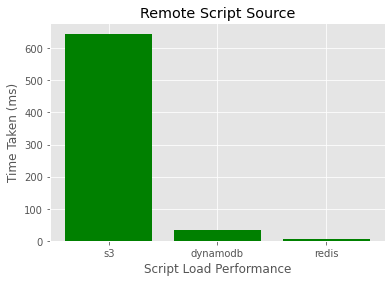

In [68]:

plt.style.use('ggplot')

x = list(iter(time_taken.keys()))
y = [x / 1000 for x in time_taken.values()]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("Script Load Performance")
plt.ylabel("Time Taken (ms)")
plt.title("Remote Script Source")

plt.xticks(x_pos, x)

plt.show()

As we can see. S3 is the slowest option while redis is fastest.

However speed may not be the only consideration. There are cost, features and resistence to data loss to think about.

To compare the merits of these choices is beyond this article. 

However I would say this. Even though redis is the fastest, it is after all an in-memory db. Which means even with its various backup strategies, there are no guarentee that committed data will not be loss (unlike s3 or dynamodb). Realistically the system would have to be setup in such a way that writes would be writting to both redis and a persistent db and only when the latter is completed would the write be considered done. Read would be just a simple read from redis. 

## What's next?

So far I have shown how you would install an S3Finder into the meta_path.

The obvious extension would be to create a generic loader for any remote source or even a union of sources.

[KYDB](https://tayglobal.github.io/kinyu-demo/src/kinyu/db/) is just the API for the job.

In the future, I will write about a library that leverages [KYDB](https://tayglobal.github.io/kinyu-demo/src/kinyu/db/) to allow a docker cluster to load code remotely.

The cool thing is that we can experiment with ideas on this cluster without redeploying any container.

## Cleaning up

Finally after we are done with our resources, we could delete them all by a simple command.

In [ ]:
client.delete_stack(StackName=stack_name)